# Setup:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as L
import torch.nn.functional as F
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

from lightning_utils import *
from MOR_Operator import MOR_Operator
from POU_net import POU_net
import JHTDB_sim_op
fields = lambda x: [name for name in vars(x) if not name.startswith('_')]

In [3]:
def load_model(path, device='cuda:6', **kwd_args):
    ''' Wraps up all the nonsense involved in loading an inference model properly into one function. '''
    kwd_args = {'n_inputs': 3, 'n_outputs': 3, 'ndims': 3} | kwd_args # user-provided kwd_args has precedence in update
    if 'VI' in path:
        print('loading VI model!')
        model = JHTDB_sim_op.PPOU_NetSimulator.load_from_checkpoint(path, **kwd_args)
    else: 
        print('loading deterministic model!')
        model = JHTDB_sim_op.POU_NetSimulator.load_from_checkpoint(path, **kwd_args)

    model = model.to(device)
    model.eval()

    # freeze everything
    for parameter in model.parameters():
        parameter.requires_grad=False
    return model

model = load_model('/scratch/dsdeigh/best_models/partial_VI_model2.ckpt')
#model = load_model('best_model3.ckpt')

loading VI model!


In [4]:
val_dataset = JHTDB_sim_op.JHTDB_Channel('data/turbulence_output', time_chunking=9)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=5, num_workers=16, shuffle=True)

# Predictive Simulation Based Calibration (aka PSBC)
First update `get_BNN_pred_distribution()` to work with aleatoric moment outputs.

In [6]:
def clear_cache():
    ''' clear pytorch cuda cache '''
    import torch, gc
    while gc.collect(): pass
    torch.cuda.empty_cache()

# Adapted to stack aleatoric moments
def get_BNN_pred_distribution(bnn_model, x_input, n_samples=100, no_grad=True):
    '''
    If you just want moments use get_BNN_pred_moments() instead as it is *much* more memory efficient (e.g. for large sample sizes). But this is still useful if you want an actual distribution.
    '''
    if no_grad:
        with torch.inference_mode():
            return get_BNN_pred_distribution(bnn_model, x_input, n_samples, no_grad=False)
    preds_mu, preds_sigma = [], []
    x_input = x_input.to(model.device)
    for i in range(n_samples):
        mu, sigma = bnn_model(x_input)
        preds_mu.append(mu)
        preds_sigma.append(sigma)
    preds_mu = torch.stack(preds_mu, axis=0)
    preds_sigma = torch.stack(preds_sigma, axis=0)
    return preds_mu, preds_sigma

# updated uses laws of total variance and expectation
def get_BNN_pred_moments(bnn_model, x_inputs, n_samples=100, no_grad=True, verbose=True):
    if no_grad:
        with torch.inference_mode():
            return get_BNN_pred_moments(bnn_model, x_inputs, n_samples=n_samples, no_grad=False, verbose=verbose)

    total_expectation = 0 # E[Y] = E[E[Y|Z]]
    total_variance = 0 # Var[Y] = E[Var[Y|Z]]+Var[E[Y|Z]]
    mus = [] # necessary for 2nd term in total variance eq.
    assert n_samples>1
    for i in range(n_samples):
        if verbose and i%print_interval==0:
            print(f'{i}th moment sample')
            utils.report_cuda_memory_usage(clear=False)
        mu, sigma = bnn_model(x_inputs.float())
        mus.append(mu)
        
        total_expectation = total_expectation + mu
        total_variance = total_variance + sigma**2

    # take average
    total_expectation = total_expectation/n_samples
    total_variance = total_variance/n_samples
    
    # add in the explained variance term (2nd term) = Var(mus) = Var[E[Y|Z]]
    total_variance = total_variance + sum([(mu-total_expectation)**2/len(mus) for mu in mus])
    
    return total_expectation, total_variance**0.5

dumb_vmap = lambda func: lambda X: torch.stack([func(x) for x in X])
# useful for debugging when vmap won't work

In [7]:
'''
%pdb off
# updated uses laws of total variance and expectation
def get_BNN_pred_moments(bnn_model, x_inputs, n_samples=100, no_grad=True, **kwd_args):
    if no_grad:
        with torch.inference_mode():
            return get_BNN_pred_moments(bnn_model, x_inputs, n_samples=n_samples, no_grad=False, **kwd_args)
    
    total_expectation = 0 # E[Y] = E[E[Y|Z]]
    total_variance = 0 # Var[Y] = E[Var[Y|Z]]+Var[E[Y|Z]]
    mus = [] # necessary for 2nd term in total variance eq.
    assert n_samples>1
    print_interval=n_samples//10

    try:
        import warnings
        warnings.filterwarnings("error")
        while len(mus)<n_samples:
            if len(mus)%print_interval==0:
                print(f'{len(mus)}th moment sample')

            try: # handle NaN samples by retrying
                mu, sigma = bnn_model(x_inputs.float(), **kwd_args)
                mus.append(mu) # will only reach here if no NaNs happened
            except UserWarning as e: # catch NaN warning
                assert 'NaNs' in str(e), 'Wrong warning caught! fix this'
                print(e) # sanity check
                continue
            
            total_expectation = total_expectation + mu
            total_variance = total_variance + sigma**2
    
        # take average
        total_expectation = total_expectation/n_samples
        total_variance = total_variance/n_samples
        
        # add in the explained variance term (2nd term) = Var(mus) = Var[E[Y|Z]]
        total_variance = total_variance + sum([(mu-total_expectation)**2/len(mus) for mu in mus])
    finally:
        warnings.resetwarnings()
    
    return total_expectation, total_variance**0.5
''';

## ALeatoric KDE Equations:

1. We want to take the union of the centroid pdfs so we sum. But then we need to make the pdf integrate to 1 $\int_{x \in \Omega} p(x) dx=1$, so we divide by the number of pdfs resulting in an average: $$p(S_{jk})={1\over N}\sum^N_{i=0}p_{ik}(S_{jk}) \text{ s.t. } S_{jk}\sim p_{jk}$$
2. However all these computations need to happen in the log domain for numerical stability: $$log(p(S_{jk}))=log({1\over N}\sum^N_{i=0}p_{ik}(S_{jk}))=log(\sum^N_{i=0}p_{ik}(S_{jk}))-log(N)$$
4. In practice this requires the Log-sum-exp trick (aka LSE): $$log(p(S_{jk}))={LSE}^N_{i=0}log(p_{ik}(S_{jk}))-log(N)$$
5. Then we need to get the joint pdf across all the spatial dimension(s) (indexed by k) $$log(p(S_j))=log(\prod_kp(S_{jk}))=\sum_k log(p(S_{jk}))$$
    6. NOTE: this is NOT marginalization, marginalization happens by summing raw PDFs we are multiplying them.

In [8]:
# GOTCHA: It seems the problem is that it always gives more liklihood to the true value than the samples? Maybe just sample more?
# That wouldn't be all bad if it were actually true it would imply that the true value always has the highest likelihood but it can't be literally true...
def _find_batch_pred_HDI_truth_quantiles(model, inputs, outputs, n_samples_per_batch, chunk_size=10, fake_ideal=False, verbose=True):
    with torch.inference_mode():
        # get sample aleatoric distributions from sampling epistemic distribution
        pred_distribution = get_BNN_pred_distribution(model, inputs, n_samples=n_samples_per_batch)
        pred_distribution = torch.distributions.normal.Normal(*pred_distribution, validate_args=False)
        pred_samples = pred_distribution.sample() # then sample the actual predictions from the sampled aleatoric distributions
        if verbose: print(f'{pred_samples.shape=}') # shape==[aleatoric_sample, batch, ...]

        import random # Verified that fake ideal works: 10/10/24
        if fake_ideal: # artificially simulate the ideal case where outputs are sampled from prediction distribution
            outputs = random.choice(pred_samples) # GOTCHA: isn't realized with small number of batches & sample sizes!
        
        def get_log_density(sample_datum):
            ''' gets log density of a single sample given the aleatoric distributions sampled from the epistemic weights '''
            # averaged_pdfs = p(S_jk) = (1/N)∑_i(p_ik(S_jk)) s.t. S_jk ~ p_jk := KDE-style pdf (derived from aleatoric distributions)
            averaged_pdfs = torch.logsumexp(pred_distribution.log_prob(sample_datum), dim=0) - np.log(n_samples_per_batch) # average across epistemic dimension
            joint_pdfs = torch.vmap(torch.sum)(averaged_pdfs) # joint pdf across all non-batch dims := log(∏_ip_i(S_i))
            return joint_pdfs

        # vmap supports additional input dimension: j (aka aleatoric sample dimension)
        #vget_log_density = dumb_vmap(get_log_density)
        vget_log_density = torch.vmap(get_log_density, chunk_size=chunk_size)
        pred_samples = pred_samples[:, None] # move the aleatoric sample dimension out of the epistemic sample distribution dimension
        assert tuple(pred_samples.shape)[:3]==(n_samples_per_batch, 1, inputs.shape[0])
        pred_joint_log_pdfs = vget_log_density(pred_samples) # shape==[aleatoric_sample, batch]
        assert tuple(pred_joint_log_pdfs.shape)==(n_samples_per_batch, inputs.shape[0])

        truth_joint_log_pdf = get_log_density(outputs[None])
        assert tuple(truth_joint_log_pdf.shape)==(inputs.shape[0],)

        if verbose:
            # plot the pdf quantile distribution(s)
            batch_display_ids = random.choices(range(inputs.shape[0]), k=1)
            for i in batch_display_ids:
                plt.hist(pred_joint_log_pdfs[:,i].cpu(), color='blue')
                plt.axvline(truth_joint_log_pdf[i].item(), color='red')
                plt.title(f'{i}th joint-log-pdf Distribution')
                plt.show()

        pdf_comparison = pred_joint_log_pdfs<=truth_joint_log_pdf
        if verbose: print(f'pdf_comparison={list(pdf_comparison.ravel().cpu().numpy())}')
        truth_quantiles = torch.sum(pdf_comparison, dim=0)/pdf_comparison.shape[0]
        assert pred_joint_log_pdfs.shape[0]==pdf_comparison.shape[0]==n_samples_per_batch
        return truth_quantiles.cpu().detach()

# Actually we don't need KDE! We can use the aleatoric uncertainty to get density directly!
def find_pred_HCI_truth_quantiles(model, data_loader, n_batches=100, n_samples_per_batch=25, chunk_size=10, fake_ideal=False, verbose=True):
    """
    These quantiles should follow q~U(0,1) in order for BCI theory to be satisfied.
    You can simulate the ideal case as a sanity check with fake_ideal=True.
    GOTCHA: In practice with small batch and/or sample sizes even with fake_ideal=True, the distribution will not look uniform!
    """
    import matplotlib.pyplot as plt
    assert model.device.type=='cuda' # TOO slow on cpu
    truth_quantiles = []
    while len(truth_quantiles)<n_batches:
        for inputs, outputs in data_loader:
            if len(truth_quantiles)==0: print(f'{inputs.shape=}, {outputs.shape=}')
            elif len(truth_quantiles)==n_batches: break
            print(f'processing batch: {len(truth_quantiles)}')
            truth_quantiles.append(_find_batch_pred_HDI_truth_quantiles(model, inputs.to(model.device), outputs.to(model.device),
                                                                        n_samples_per_batch=n_samples_per_batch, fake_ideal=fake_ideal,
                                                                        chunk_size=chunk_size, verbose=verbose))
    truth_quantiles = torch.cat(truth_quantiles)
    display_quantiles = list(torch.quantile(truth_quantiles, q=torch.linspace(0.0,1.0, steps=5)).numpy())
    print('1/5th quantiles of truth quantile distribution: ', display_quantiles)
    plt.hist(truth_quantiles)
    plt.title('Truth Quantiles (Should follow q~U(0,1))')
    plt.show()
    return truth_quantiles

Automatic pdb calling has been turned ON
inputs.shape=torch.Size([5, 3, 103, 26, 77]), outputs.shape=torch.Size([5, 3, 103, 26, 77, 8])
processing batch: 0
pred_samples.shape=torch.Size([25, 5, 3, 103, 26, 77, 8])


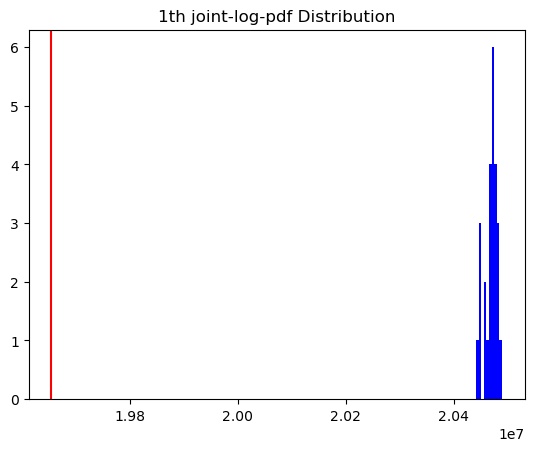

pdf_comparison=[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
processing batch: 1
pred_samples.shape=torch.Size([25, 5, 3, 103, 26, 77, 8])


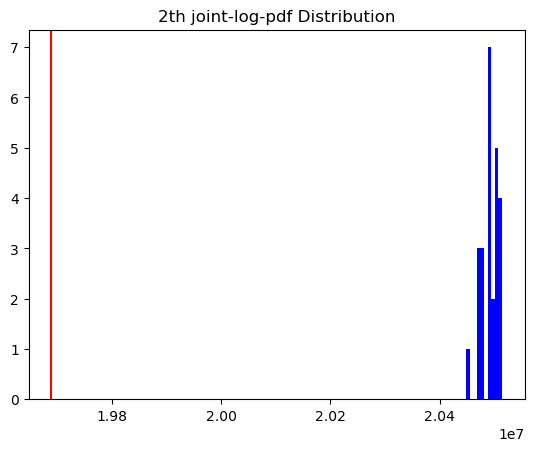

pdf_comparison=[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
processing batch: 2
pred_samples.shape=torch.Size([25, 5, 3, 103, 26, 77, 8])


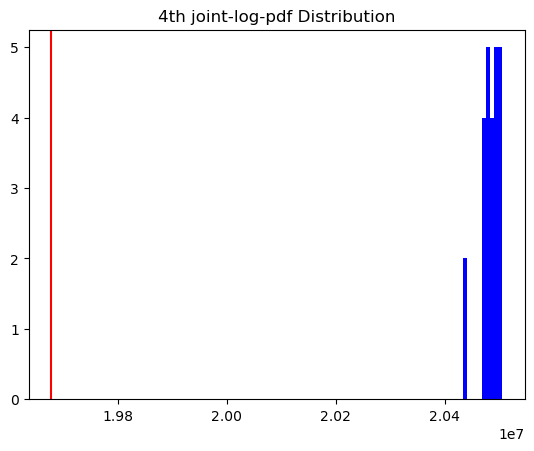

pdf_comparison=[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
processing batch: 3


KeyboardInterrupt: 

> /home/dsdeigh/MOR_MoEs/JHTDB_sim_op.py(208)evolve()
    206             u, uq = self.op.forward(NSupd(u), uq)
    207             if divergence_free: u = divergence_free_constraint(u)
--> 208             if u.isnan().any() or uq.isnan().any():
    209                 warnings.warn(f'Simulation has diverged into NaNs! At step: {i}')
    210             #assert not (u.isnan().any() or uq.isnan().any())



ipdb>  q


In [9]:
%pdb on
truth_quantiles = find_pred_HCI_truth_quantiles(model, val_data_loader, n_batches=10, n_samples_per_batch=25, chunk_size=2, fake_ideal=False, verbose=True)

In [8]:
np.savetxt('truth_quantiles.txt', truth_quantiles.numpy())

## Posterior-Predictive Check

$PPC_{LL}=log(p(D_{new}|D))=log(\int p(D_{new}|\theta)*p(\theta|D)d\theta)$

$=log(E_\theta[p(D_{new})])$

In [ ]:
def log_posterior_predictive_check(model, val_data_loader, n_samples = 100):
    PPC_LL = torch.tensor(0)
    with torch.inference_mode():
        for i in range(n_samples):
            for X, y in val_data_loader:
                mu, sigma = model(X.to(model.device))
                normal = torch.distributions.normal.Normal(mu, sigma)
                PPC_LL = torch.logaddexp(PPC_LL, normal.log_prob(y.to(model.device)).sum())
        PPC_LL = PPC_LL-torch.log(n_samples*len(val_data_loader.dataset))
    PPC_LL = PPC_LL.item()
    print(f'{PPC_LL=}')
    return PPC_LL
log_posterior_predictive_check(model, val_data_loader)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:6! (when checking argument for argument other in method wrapper_CUDA_logaddexp)

> /tmp/ipykernel_2341479/2156579980.py(8)log_posterior_predictive_check()
      6                 mu, sigma = model(X.to(model.device))
      7                 normal = torch.distributions.normal.Normal(mu, sigma)
----> 8                 PPC_LL = torch.logaddexp(PPC_LL, normal.log_prob(y.to(model.device)).sum())
      9         PPC_LL = PPC_LL-torch.log(n_samples*len(val_data_loader.dataset))
     10     PPC_LL = PPC_LL.item()



## Scratch Space for Developing and Debugging:

In [ ]:
data_iter = iter(val_data_loader)
inputs, outputs = next(data_iter)
print(f'{inputs.shape=}, {outputs.shape=}')

In [ ]:
pred_mu, pred_sigma = get_BNN_pred_distribution(model, inputs.to(model.device), n_samples=10)
pred_distribution = torch.distributions.normal.Normal(pred_mu, pred_sigma)
print(f'{pred_distribution=}')

In [ ]:
samples = pred_distribution.sample()

In [ ]:
samples = samples[:, None]

In [ ]:
print(f'{outputs.shape=}')
print(f'{samples.shape=}')
print(f'{pred_distribution.loc.shape=}')

In [ ]:
ll = pred_distribution.log_prob(outputs.to(model.device))
print(f'{ll.shape=}')